In [1]:
import pyodbc
import re
import warnings
import pandas as pd
from nltk.tokenize import word_tokenize
from gensim import corpora
import gensim
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import numpy as np
import nltk

nltk.download('punkt')
warnings.filterwarnings('ignore')


conn = pyodbc.connect(DRIVER='{ODBC Driver 17 for SQL Server}', SERVER='MED000008696', DATABASE='Difods_Analytics', Trusted_Connection='yes')
cursor = conn.cursor()

comentarios_total_foros = pd.read_sql_query("SELECT campus, curid, idnumber, MENSAJE FROM [Difods_Analytics].dbo.FORO_2021 WHERE (TIPO_FORO='general' AND NOMBRE_ACTIVIDAD IN ('Foro de presentación', 'Foro presentación') AND ROL='student')", conn)

C:\ProgramData\Miniconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ccuro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def procesamiento_comentario(sentence: str):

    tokens = word_tokenize(sentence)
    
    return tokens

def conversion_num_topico(topico):
    
    if (topico == 0 or topico == 1 or topico == 3):
        return 0.5
    elif topico == 2:
        return 1
    else:
        return 0

In [3]:
comentarios_total_foros.head(10)

,campus,curid,idnumber,MENSAJE
0,9,2,09764659,
1,4,7,,
2,4,7,17925406,Les saluda Ela del Carmen Saldaña Pinedo de la...
3,4,42,10519536,Saludos y buenas vibras para todos:Jeanette Ab...
4,4,42,21138248,Mis efusivos Saludos a\r\ncada uno de los part...
5,4,42,40206936,Con el saludo del día a cada uno de ustedes qu...
6,4,42,70077668,buenos dias mi nombre es Lidia Bludith Sanchez...
7,4,42,45445165,Hola buenos días mi Nombre es Patricia Fasabi ...
8,4,42,74127423,bueno mi nombre es santa Eulalia Carhuapoma Ve...
9,4,42,74127423,bueno mi nombre es santa Eulalia Carhuapoma Ve...


In [4]:
comentarios_total_foros['Comentario_original'] = comentarios_total_foros['MENSAJE']
comentarios_total_foros.drop(['MENSAJE'], axis=1, inplace=True)

comentarios_total_foros_originales = list(comentarios_total_foros['Comentario_original'])

comentarios_total_foros_preprocesados = []
for i, comm in enumerate(comentarios_total_foros_originales):
    comm_prepro = comm.lower()
    
    comm_prepro = re.sub(r'[áàä]', 'a', comm_prepro)
    comm_prepro = re.sub(r'[éèë]', 'e', comm_prepro)
    comm_prepro = re.sub(r'[íìï]', 'i', comm_prepro)
    comm_prepro = re.sub(r'[óòö]', 'o', comm_prepro)
    comm_prepro = re.sub(r'[úùü]', 'u', comm_prepro)
    
    comm_prepro = re.sub(r'[\d\.,\'\]\[\"¿?¡!“”;%\(\)/:@&#*_-]', '', comm_prepro)
    
    comm_prepro = re.sub(r' +', ' ', comm_prepro)
       
    if comm_prepro!= '' and comm_prepro[0] == ' ':
        comm_prepro = comm_prepro[1:]
    
    if comm_prepro!= '' and comm_prepro[-1] == ' ':
        comm_prepro = comm_prepro[:-1]
    
    comentarios_total_foros_preprocesados.append(comm_prepro)

comentarios_total_foros['Comentario_preprocesado'] = comentarios_total_foros_preprocesados

comentarios_total_foros.drop(comentarios_total_foros[comentarios_total_foros['Comentario_preprocesado'] == ''].index, inplace = True)

#comentarios_total_foros.reset_index(inplace=True)

In [5]:
comentarios_total_foros

,campus,curid,idnumber,Comentario_original,Comentario_preprocesado
2,4,7,17925406,Les saluda Ela del Carmen Saldaña Pinedo de la...,les saluda ela del carmen saldaña pinedo de la...
3,4,42,10519536,Saludos y buenas vibras para todos:Jeanette Ab...,saludos y buenas vibras para todosjeanette aba...
4,4,42,21138248,Mis efusivos Saludos a\r\ncada uno de los part...,mis efusivos saludos a\r\ncada uno de los part...
5,4,42,40206936,Con el saludo del día a cada uno de ustedes qu...,con el saludo del dia a cada uno de ustedes qu...
6,4,42,70077668,buenos dias mi nombre es Lidia Bludith Sanchez...,buenos dias mi nombre es lidia bludith sanchez...
...,...,...,...,...,...
677221,2,55,20428656,Soy la profesora Francisca\r\nRosario Rojas To...,soy la profesora francisca\r\nrosario rojas to...
677222,2,55,21073652,"Buen día a todos los colegas, soy Marco Antoni...",buen dia a todos los colegas soy marco antonio...
677223,2,55,45838839,"Buenas tardes maestros, un curso bastante inte...",buenas tardes maestros un curso bastante inter...
677224,2,55,20428074,"Buenas noches estimados colegas, soy Lucila Lu...",buenas noches estimados colegas soy lucila luz...


In [6]:
stopwords_considerados = ['el', 'la', 'al', 'que', 'para', 'de', 'en', 'es', 'los', 'y', 'con', 'a', 'las', 'del', 
                          'me', 'mi', 'se', 'por', 'lo', 'ya', 'un', 'pero', 'una', 'nos', 'mis', 'o', 'esta', 'este',
                          'e', 'su', 'traves', 'sobre', 'como', 'sus', 'muy']

In [7]:
comentarios_total_foros_preprocesados_sin_stopwords = []
for commp in list(comentarios_total_foros.Comentario_preprocesado):
    list_words = commp.split(' ')
    comm_proc_sin_stopwords = [word for word in list_words if word not in stopwords_considerados]

    comm_temp = ''
    for i, cpssw in enumerate(comm_proc_sin_stopwords):
        if i != len(comm_proc_sin_stopwords) - 1:
            comm_temp += cpssw + ' '
        else:
            comm_temp += cpssw
    comentarios_total_foros_preprocesados_sin_stopwords.append(comm_temp)

comentarios_total_foros['Comentario_preprocesado2'] = comentarios_total_foros_preprocesados_sin_stopwords

In [8]:
comentarios_total_foros

,campus,curid,idnumber,Comentario_original,Comentario_preprocesado,Comentario_preprocesado2
2,4,7,17925406,Les saluda Ela del Carmen Saldaña Pinedo de la...,les saluda ela del carmen saldaña pinedo de la...,les saluda ela carmen saldaña pinedo region li...
3,4,42,10519536,Saludos y buenas vibras para todos:Jeanette Ab...,saludos y buenas vibras para todosjeanette aba...,saludos buenas vibras todosjeanette abanto zor...
4,4,42,21138248,Mis efusivos Saludos a\r\ncada uno de los part...,mis efusivos saludos a\r\ncada uno de los part...,efusivos saludos a\r\ncada uno participantes\r...
5,4,42,40206936,Con el saludo del día a cada uno de ustedes qu...,con el saludo del dia a cada uno de ustedes qu...,saludo dia cada uno ustedes quien saluda edith...
6,4,42,70077668,buenos dias mi nombre es Lidia Bludith Sanchez...,buenos dias mi nombre es lidia bludith sanchez...,buenos dias nombre lidia bludith sanchez riva ...
...,...,...,...,...,...,...
677221,2,55,20428656,Soy la profesora Francisca\r\nRosario Rojas To...,soy la profesora francisca\r\nrosario rojas to...,soy profesora francisca\r\nrosario rojas tolen...
677222,2,55,21073652,"Buen día a todos los colegas, soy Marco Antoni...",buen dia a todos los colegas soy marco antonio...,buen dia todos colegas soy marco antonio machu...
677223,2,55,45838839,"Buenas tardes maestros, un curso bastante inte...",buenas tardes maestros un curso bastante inter...,buenas tardes maestros curso bastante interesa...
677224,2,55,20428074,"Buenas noches estimados colegas, soy Lucila Lu...",buenas noches estimados colegas soy lucila luz...,buenas noches estimados colegas soy lucila luz...


In [12]:
comentarios_total_foros.Comentario_preprocesado2[2]

'les saluda ela carmen saldaña pinedo region libertad trujillo docente universidad catolica trujillo benedicto xvi tengo practica pre profesional final i ix ciclo educacion especial soy docente educacion inicial especial he elegido curso porque quiero seguir ampliando conocimientos poniendo practica niños nee tengo altas expectativas curso gracias'

In [13]:
comentarios_total_foros['Comentario_procesado'] = comentarios_total_foros['Comentario_preprocesado2'].apply(procesamiento_comentario)

In [14]:
comentarios_total_foros

,campus,curid,idnumber,Comentario_original,Comentario_preprocesado,Comentario_preprocesado2,Comentario_procesado
2,4,7,17925406,Les saluda Ela del Carmen Saldaña Pinedo de la...,les saluda ela del carmen saldaña pinedo de la...,les saluda ela carmen saldaña pinedo region li...,"[les, saluda, ela, carmen, saldaña, pinedo, re..."
3,4,42,10519536,Saludos y buenas vibras para todos:Jeanette Ab...,saludos y buenas vibras para todosjeanette aba...,saludos buenas vibras todosjeanette abanto zor...,"[saludos, buenas, vibras, todosjeanette, abant..."
4,4,42,21138248,Mis efusivos Saludos a\r\ncada uno de los part...,mis efusivos saludos a\r\ncada uno de los part...,efusivos saludos a\r\ncada uno participantes\r...,"[efusivos, saludos, a, cada, uno, participante..."
5,4,42,40206936,Con el saludo del día a cada uno de ustedes qu...,con el saludo del dia a cada uno de ustedes qu...,saludo dia cada uno ustedes quien saluda edith...,"[saludo, dia, cada, uno, ustedes, quien, salud..."
6,4,42,70077668,buenos dias mi nombre es Lidia Bludith Sanchez...,buenos dias mi nombre es lidia bludith sanchez...,buenos dias nombre lidia bludith sanchez riva ...,"[buenos, dias, nombre, lidia, bludith, sanchez..."
...,...,...,...,...,...,...,...
677221,2,55,20428656,Soy la profesora Francisca\r\nRosario Rojas To...,soy la profesora francisca\r\nrosario rojas to...,soy profesora francisca\r\nrosario rojas tolen...,"[soy, profesora, francisca, rosario, rojas, to..."
677222,2,55,21073652,"Buen día a todos los colegas, soy Marco Antoni...",buen dia a todos los colegas soy marco antonio...,buen dia todos colegas soy marco antonio machu...,"[buen, dia, todos, colegas, soy, marco, antoni..."
677223,2,55,45838839,"Buenas tardes maestros, un curso bastante inte...",buenas tardes maestros un curso bastante inter...,buenas tardes maestros curso bastante interesa...,"[buenas, tardes, maestros, curso, bastante, in..."
677224,2,55,20428074,"Buenas noches estimados colegas, soy Lucila Lu...",buenas noches estimados colegas soy lucila luz...,buenas noches estimados colegas soy lucila luz...,"[buenas, noches, estimados, colegas, soy, luci..."


In [25]:
######################## LDA ############################################

dictionary = corpora.Dictionary(comentarios_total_foros['Comentario_procesado'])
corpus = [dictionary.doc2bow(text) for text in comentarios_total_foros['Comentario_procesado']]

NUM_TOPICS = 5

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15, random_state=123)
topics = ldamodel.print_topics(num_words=4)

for topic in topics:
    print(topic)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=comentarios_total_foros['Comentario_procesado'], dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

lda_display = gensimvis.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

(0, '0.022*"curso" + 0.019*"dia" + 0.018*"todos" + 0.016*"buen"')
(1, '0.048*"buenas" + 0.047*"docente" + 0.045*"soy" + 0.039*"curso"')
(2, '0.045*"distrito" + 0.045*"ie" + 0.037*"provincia" + 0.030*"soy"')
(3, '0.047*"digital" + 0.034*"competencia" + 0.026*"curso" + 0.021*"region"')
(4, '0.048*"herramientas" + 0.034*"estudiantes" + 0.029*"tecnologicas" + 0.025*"digitales"')

Coherence Score:  -2.0746559415275763


In [26]:
num_words = 4
list_coherence_lda = []

for nt in range(3,18):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = nt, id2word=dictionary, passes=15, random_state=123)
    topics = ldamodel.print_topics(num_words=num_words)
    
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=comentarios_total_foros['Comentario_procesado'], dictionary=dictionary, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    
    list_coherence_lda.append(coherence_lda)

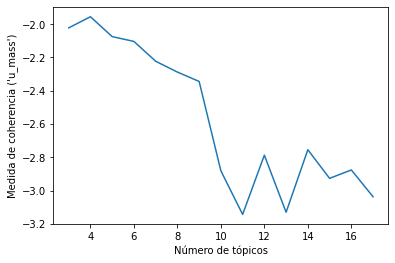

In [29]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(3,17,15), np.array(list_coherence_lda))
plt.xlabel('Número de tópicos')
plt.ylabel('Medida de coherencia (\'u_mass\')')
plt.show()

In [30]:
df_coherence_lda = pd.DataFrame()
df_coherence_lda['METODO'] = [i for i in ['LDA'] for r in range(len(list_coherence_lda))]
df_coherence_lda['NRO_TOPICOS'] = np.linspace(3,17,15)
df_coherence_lda['COHERENCIA'] = list_coherence_lda

In [31]:
df_coherence_lda

,METODO,NRO_TOPICOS,COHERENCIA
0,LDA,3.0,-2.022094
1,LDA,4.0,-1.955254
2,LDA,5.0,-2.074656
3,LDA,6.0,-2.103530
4,LDA,7.0,-2.222664
5,LDA,8.0,-2.287783
6,LDA,9.0,-2.344155
7,LDA,10.0,-2.881295
8,LDA,11.0,-3.143186
9,LDA,12.0,-2.787291


In [15]:
dictionary = corpora.Dictionary(comentarios_total_foros['Comentario_procesado'])
corpus = [dictionary.doc2bow(text) for text in comentarios_total_foros['Comentario_procesado']]

NUM_TOPICS = 4

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15, random_state=123)
topics = ldamodel.print_topics(num_words=4)

for topic in topics:
    print(topic)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=comentarios_total_foros['Comentario_procesado'], dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

lda_display = gensimvis.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

(0, '0.031*"provincia" + 0.030*"soy" + 0.029*"ie" + 0.028*"docente"')
(1, '0.033*"docente" + 0.027*"curso" + 0.022*"soy" + 0.021*"buenas"')
(2, '0.049*"docente" + 0.048*"soy" + 0.043*"buenas" + 0.036*"curso"')
(3, '0.030*"curso" + 0.019*"participar" + 0.017*"todos" + 0.014*"estoy"')

Coherence Score:  -1.974945143301196


In [16]:
topics = ldamodel.print_topics(num_words=8)

for topic in topics:
    print(topic)

(0, '0.031*"provincia" + 0.030*"soy" + 0.029*"ie" + 0.028*"docente" + 0.025*"distrito" + 0.025*"region" + 0.020*"buenas" + 0.019*"san"')
(1, '0.033*"docente" + 0.027*"curso" + 0.022*"soy" + 0.021*"buenas" + 0.020*"practica" + 0.020*"expectativas" + 0.019*"estudiantes" + 0.017*"nombre"')
(2, '0.049*"docente" + 0.048*"soy" + 0.043*"buenas" + 0.036*"curso" + 0.034*"nombre" + 0.029*"region" + 0.027*"nivel" + 0.024*"noches"')
(3, '0.030*"curso" + 0.019*"participar" + 0.017*"todos" + 0.014*"estoy" + 0.013*"digital" + 0.013*"poder" + 0.011*"virtual" + 0.010*"saludo"')


In [17]:
comentarios_total_foros.Comentario_original[2]

'Les saluda Ela del Carmen Saldaña Pinedo de la Región La Libertad- Trujillo docente del Universidad Católica de Trujillo "Benedicto XVI" tengo la práctica pre profesional Final I del IX ciclo de Educación Especial , soy docente de Educación Inicial y Especial he elegido este curso porque quiero seguir ampliando mis conocimientos y poniendo en práctica en los niños con NEE tengo muy altas expectativas de este curso. Gracias.'

In [18]:
list_prob_topic = []
for pt in ldamodel.get_document_topics(corpus[0]):
    (_, prob) = pt
    list_prob_topic.append(prob)
    
id_max_prob = np.argmax(list_prob_topic)

print(list_prob_topic)
print(id_max_prob)

[0.107726656, 0.3282995, 0.2071996, 0.35677424]
3


In [19]:
list_topicos_comentarios = []
for c in corpus:
    list_prob_topic = []
    for pt in ldamodel.get_document_topics(c):
        (_, prob) = pt
        list_prob_topic.append(prob)
    id_max_prob = np.argmax(list_prob_topic)
    list_topicos_comentarios.append(id_max_prob)

In [20]:
comentarios_total_foros['TOPICO'] = list_topicos_comentarios

In [21]:
comentarios_total_foros

,campus,curid,idnumber,Comentario_original,Comentario_preprocesado,Comentario_preprocesado2,Comentario_procesado,TOPICO
2,4,7,17925406,Les saluda Ela del Carmen Saldaña Pinedo de la...,les saluda ela del carmen saldaña pinedo de la...,les saluda ela carmen saldaña pinedo region li...,"[les, saluda, ela, carmen, saldaña, pinedo, re...",3
3,4,42,10519536,Saludos y buenas vibras para todos:Jeanette Ab...,saludos y buenas vibras para todosjeanette aba...,saludos buenas vibras todosjeanette abanto zor...,"[saludos, buenas, vibras, todosjeanette, abant...",1
4,4,42,21138248,Mis efusivos Saludos a\r\ncada uno de los part...,mis efusivos saludos a\r\ncada uno de los part...,efusivos saludos a\r\ncada uno participantes\r...,"[efusivos, saludos, a, cada, uno, participante...",2
5,4,42,40206936,Con el saludo del día a cada uno de ustedes qu...,con el saludo del dia a cada uno de ustedes qu...,saludo dia cada uno ustedes quien saluda edith...,"[saludo, dia, cada, uno, ustedes, quien, salud...",2
6,4,42,70077668,buenos dias mi nombre es Lidia Bludith Sanchez...,buenos dias mi nombre es lidia bludith sanchez...,buenos dias nombre lidia bludith sanchez riva ...,"[buenos, dias, nombre, lidia, bludith, sanchez...",1
...,...,...,...,...,...,...,...,...
677221,2,55,20428656,Soy la profesora Francisca\r\nRosario Rojas To...,soy la profesora francisca\r\nrosario rojas to...,soy profesora francisca\r\nrosario rojas tolen...,"[soy, profesora, francisca, rosario, rojas, to...",0
677222,2,55,21073652,"Buen día a todos los colegas, soy Marco Antoni...",buen dia a todos los colegas soy marco antonio...,buen dia todos colegas soy marco antonio machu...,"[buen, dia, todos, colegas, soy, marco, antoni...",2
677223,2,55,45838839,"Buenas tardes maestros, un curso bastante inte...",buenas tardes maestros un curso bastante inter...,buenas tardes maestros curso bastante interesa...,"[buenas, tardes, maestros, curso, bastante, in...",0
677224,2,55,20428074,"Buenas noches estimados colegas, soy Lucila Lu...",buenas noches estimados colegas soy lucila luz...,buenas noches estimados colegas soy lucila luz...,"[buenas, noches, estimados, colegas, soy, luci...",0


In [22]:
comentarios_total_foros['PUNTUACION_FORO'] = comentarios_total_foros['TOPICO'].apply(conversion_num_topico)

In [25]:
comentarios_total_foros

,campus,curid,idnumber,Comentario_original,Comentario_preprocesado,Comentario_preprocesado2,Comentario_procesado,TOPICO,PUNTUACION_FORO
2,4,7,17925406,Les saluda Ela del Carmen Saldaña Pinedo de la...,les saluda ela del carmen saldaña pinedo de la...,les saluda ela carmen saldaña pinedo region li...,"[les, saluda, ela, carmen, saldaña, pinedo, re...",3,0.5
3,4,42,10519536,Saludos y buenas vibras para todos:Jeanette Ab...,saludos y buenas vibras para todosjeanette aba...,saludos buenas vibras todosjeanette abanto zor...,"[saludos, buenas, vibras, todosjeanette, abant...",1,0.5
4,4,42,21138248,Mis efusivos Saludos a\r\ncada uno de los part...,mis efusivos saludos a\r\ncada uno de los part...,efusivos saludos a\r\ncada uno participantes\r...,"[efusivos, saludos, a, cada, uno, participante...",2,1.0
5,4,42,40206936,Con el saludo del día a cada uno de ustedes qu...,con el saludo del dia a cada uno de ustedes qu...,saludo dia cada uno ustedes quien saluda edith...,"[saludo, dia, cada, uno, ustedes, quien, salud...",2,1.0
6,4,42,70077668,buenos dias mi nombre es Lidia Bludith Sanchez...,buenos dias mi nombre es lidia bludith sanchez...,buenos dias nombre lidia bludith sanchez riva ...,"[buenos, dias, nombre, lidia, bludith, sanchez...",1,0.5
...,...,...,...,...,...,...,...,...,...
677221,2,55,20428656,Soy la profesora Francisca\r\nRosario Rojas To...,soy la profesora francisca\r\nrosario rojas to...,soy profesora francisca\r\nrosario rojas tolen...,"[soy, profesora, francisca, rosario, rojas, to...",0,0.5
677222,2,55,21073652,"Buen día a todos los colegas, soy Marco Antoni...",buen dia a todos los colegas soy marco antonio...,buen dia todos colegas soy marco antonio machu...,"[buen, dia, todos, colegas, soy, marco, antoni...",2,1.0
677223,2,55,45838839,"Buenas tardes maestros, un curso bastante inte...",buenas tardes maestros un curso bastante inter...,buenas tardes maestros curso bastante interesa...,"[buenas, tardes, maestros, curso, bastante, in...",0,0.5
677224,2,55,20428074,"Buenas noches estimados colegas, soy Lucila Lu...",buenas noches estimados colegas soy lucila luz...,buenas noches estimados colegas soy lucila luz...,"[buenas, noches, estimados, colegas, soy, luci...",0,0.5


In [24]:
sql_query_insert = "INSERT INTO [Difods_Analytics].dbo.DATA_PUNTUACION_MODELO_PERCEPCION (campus_mp,curid_mp,idnumber_mp,PUNTUACION_FORO) VALUES (?,?,?,?)"
val = comentarios_total_foros[['campus', 'curid', 'idnumber', 'PUNTUACION_FORO']].values.tolist()

cursor.executemany(sql_query_insert, val)
conn.commit()

In [107]:
conn.close()